# KSA: Polar Observations and Modelling

# Week 7 - Isolating the effect of meltwater

We can further isolate the effects of meltwater changes by looking at the difference between our two simulations:

$$
MELTWATER = EXP(THERMAL+WIND+PRECIP+MELTWATER) - EXP(THERMAL+WIND+PRECIP)
$$

This saves us the cost of running another model experiment with just meltwater - remember that these are global, high resolution models that are expensive to run and produce large amounts of data.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import gsw
import matplotlib.lines as mlines
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr
import xarrayMannKendall as xrmk

In [2]:
def stereographic_axis(ax):
    
    ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='gainsboro',
                                            facecolor='gainsboro'))
    ax.coastlines(resolution = "110m")
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    return ax

## Load experiment data

Let's load all three experiments, and substract the perturbations to get our "meltwater only" results:

In [3]:
path_ctrl = glob.glob('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class8/data/control*.nc') 
control = xr.open_mfdataset(path_ctrl, chunks = 'auto')

In [4]:
path_pert = glob.glob('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class8/data/ssp585*.nc') 
exp_585 = xr.open_mfdataset(path_pert, chunks = 'auto')

In [5]:
path_pert = glob.glob('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class8/data/mw_ssp585*.nc') 
exp_585_mw = xr.open_mfdataset(path_pert, chunks = 'auto')

In [7]:
mw = exp_585_mw - exp_585

## Changes to temperature and salinity

This time, to get the anomalies, we don't need the control simulation. We just need the `mw` files. Why?

Remember that the anomalies of our simulation are calculated as:

```
temp_anom = exp_585 - control
temp_anom_mw = exp_585_mw - control
```

And so the anomalies of just meltwater would be:

```
temp_anom_only_mw = temp_anom_mw - temp_anom = exp_585_mw - exp_585
```

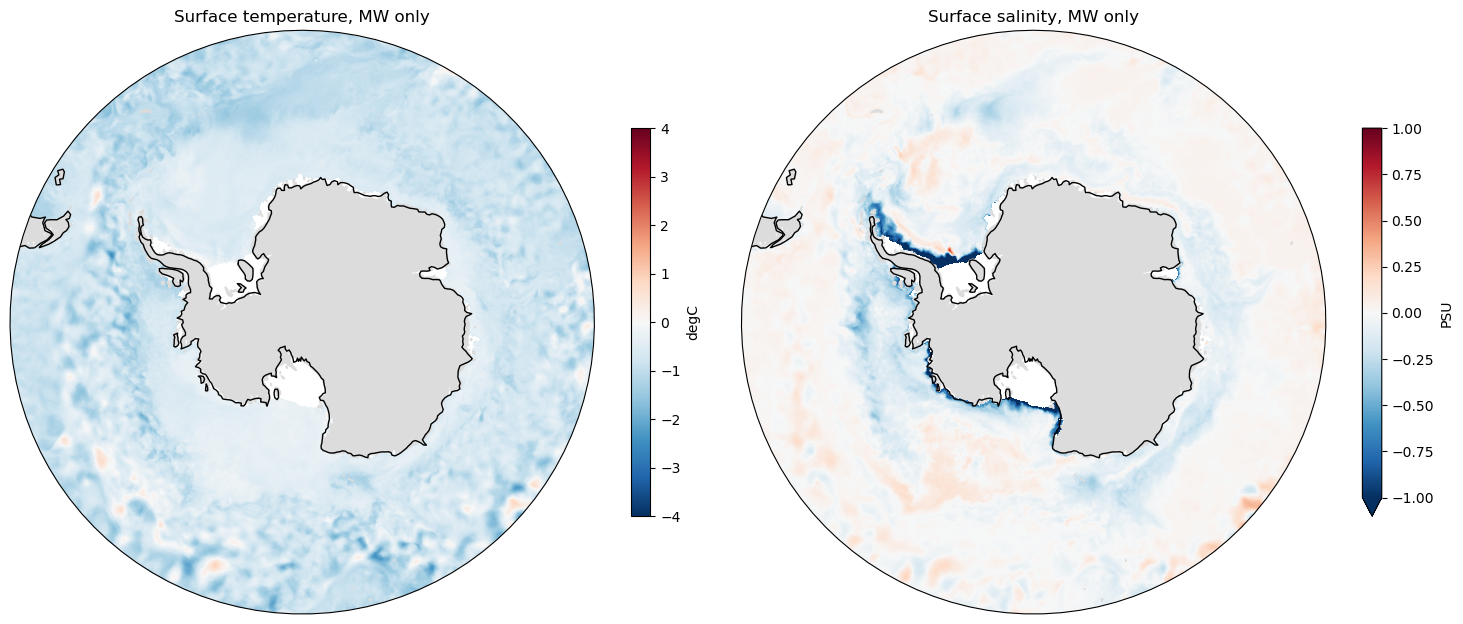

In [15]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(121, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(122, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

mw['temp'].sel(st_ocean = 0, method = 'nearest').plot(ax = axs[0], cmap = 'RdBu_r', vmin = -4, vmax = 4,
                                                     transform = ccrs.PlateCarree(),
                                                     cbar_kwargs = {'label':'degC', 'shrink':0.4})
axs[0].set_title('Surface temperature, MW only');

mw['salt'].sel(st_ocean = 0, method = 'nearest').plot(ax = axs[1], cmap = 'RdBu_r', vmin = -1, vmax = 1,
                                                     transform = ccrs.PlateCarree(),
                                                     cbar_kwargs = {'label':'PSU', 'shrink':0.4})
axs[1].set_title('Surface salinity, MW only');

plt.tight_layout();

These are very different to the two individual simulations. Why do you think that is?

Now let's calculate bottom temperature and salinities:

In [16]:
mask = xr.where(np.isnan(control['temp']), 0, 1)
mask = mask.cumsum('st_ocean')
bottom_level = mask.argmax('st_ocean')

In [17]:
bottom_level = bottom_level.compute()

In [19]:
temp_anom_b = mw['temp'].isel(st_ocean = bottom_level)
salt_anom_b = mw['salt'].isel(st_ocean = bottom_level)

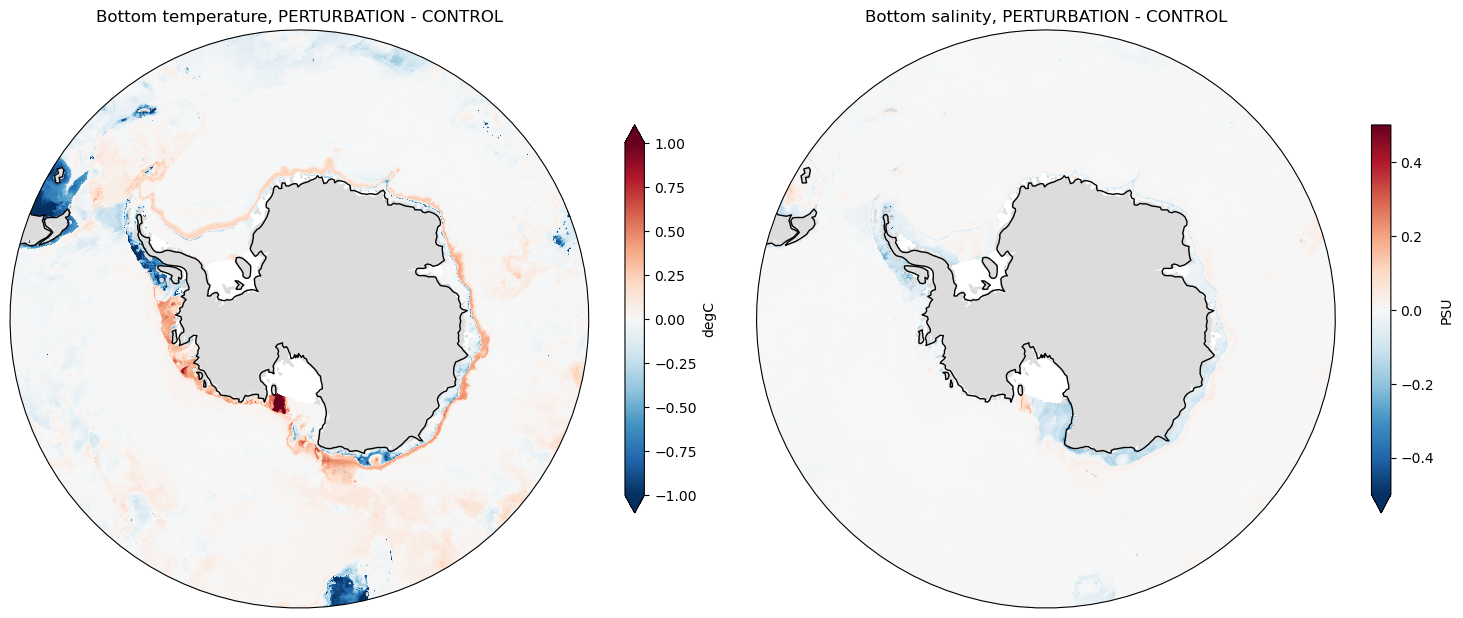

In [20]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(121, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(122, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

temp_anom_b.plot(ax = axs[0], cmap = 'RdBu_r', vmin = -1, vmax = 1,
                 transform = ccrs.PlateCarree(), cbar_kwargs = {'label':'degC', 'shrink':0.4})
axs[0].set_title('Bottom temperature, PERTURBATION - CONTROL');

salt_anom_b.plot(ax = axs[1], cmap = 'RdBu_r', vmin = -.5, vmax = .5,
                 transform = ccrs.PlateCarree(), cbar_kwargs = {'label':'PSU', 'shrink':0.4})
axs[1].set_title('Bottom salinity, PERTURBATION - CONTROL');

plt.tight_layout();

## Changes to Drake Passage transport

In the same way we don't need the control to calculate the temperature anomalies, calculating the DP transport from the `mw` dataset will just give us the *change* in transport associated to meltwater only. 

In [21]:
T_mw = mw['tx_trans_int_z']/(1035*1e6)
ψ_mw = T_mw.cumsum('yt_ocean')

In [24]:
ψ_south_america = ψ_mw.sel(xu_ocean = -68, yt_ocean = -55, method = 'nearest')
ψ_antarctic_pen = ψ_mw.sel(xu_ocean = -62, yt_ocean = -64, method = 'nearest')
DP_transport_mw = ψ_south_america - ψ_antarctic_pen

In [25]:
DP_transport_mw.values

array(-7.8995442, dtype=float32)

#### Question 1

This is the change to the DP transport due only to meltwater. How does it compare to the changes in the two indvidual simulations from last class? What's the relationship between them?

*Answer here*

## Changes to the MOC

Let's calculate changes to the strength of the MOC. 

In [29]:
Ty_rho = mw['ty_trans_rho'] / (1035*1e6)
Ty_rho_int_x = Ty_rho.sum('grid_xt_ocean')
ψ_mw = Ty_rho_int_x.cumsum('potrho') 

In [30]:
levels =  np.hstack((np.arange(-35, 0, 4), np.flip(-np.arange(-35, 0, 4))))
cbarticks = np.hstack((np.flip(-np.arange(3, 35, 6)), np.arange(3, 35, 6)))

In [31]:
MOC_mw = ψ_mw.sel(potrho = slice(None, 1036)).min().values

In [32]:
MOC_mw

array(-15.71787, dtype=float32)

#### Question 2

Similar to the Drake Passage transport, this represents the *change* in the strength of the MOC due to meltwater only. How does it compare to the strength of the individual simulations?

*Answer here*

## Antarctic Slope Current changes

In [35]:
asc_fresh_c = control['u'].sel(xu_ocean = slice(-10, 10), yu_ocean = slice(-72, -68), st_ocean = slice(None, 1500)).mean('xu_ocean')
asc_fresh_p = mw['u'].sel(xu_ocean = slice(-10, 10), yu_ocean = slice(-72, -68), st_ocean = slice(None, 1500)).mean('xu_ocean')

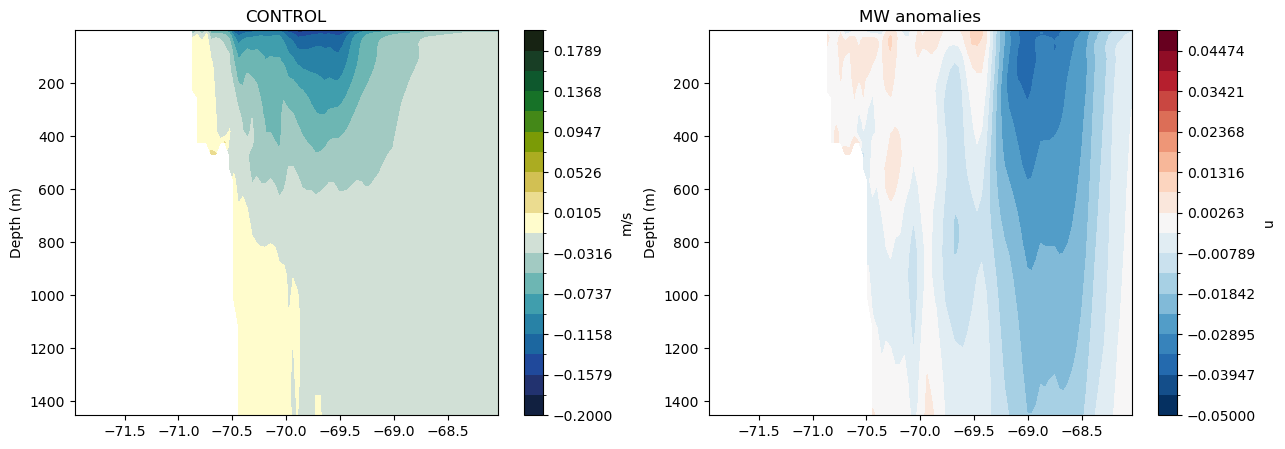

In [42]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
asc_fresh_c.plot.contourf(ax = axs[0], levels = 20, vmin = -.2, vmax = .2, cmap = cm.cm.delta,
                          cbar_kwargs = {'label':'m/s'})
asc_fresh_p.plot.contourf(ax = axs[1], levels = 20, vmin = -.05, vmax = .05, cmap = 'RdBu_r')
axs[0].set_title('CONTROL')
axs[1].set_title('MW anomalies')
for ax in axs:
    ax.invert_yaxis();
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('');

In [38]:
asc_dense_c = control['u'].sel(xu_ocean = slice(-240, -230), yu_ocean = slice(-67.5, -64), st_ocean = slice(None, 4000)).mean('xu_ocean')
asc_dense_p = mw['u'].sel(xu_ocean = slice(-240, -230), yu_ocean = slice(-67.5, -64), st_ocean = slice(None, 4000)).mean('xu_ocean')

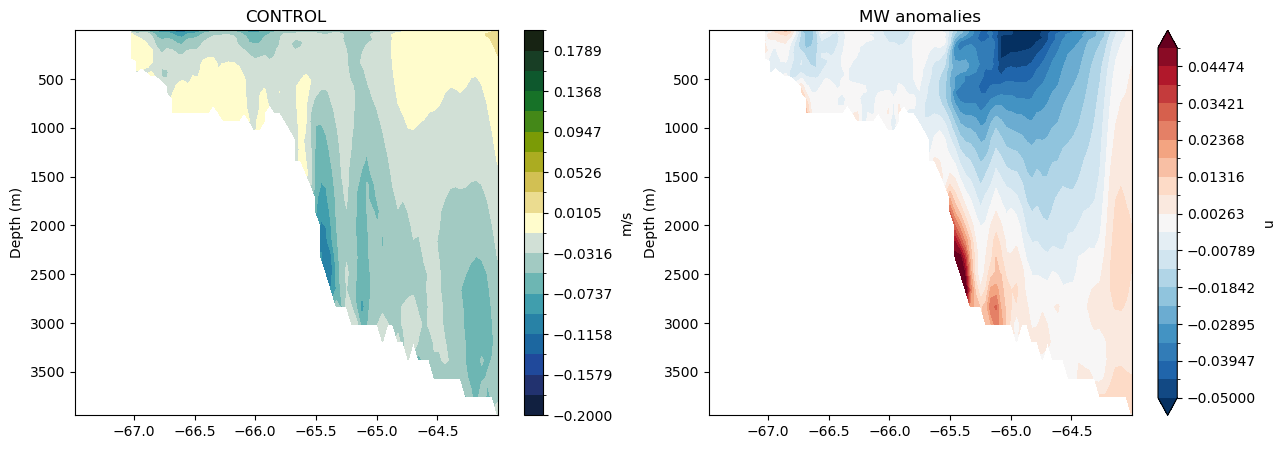

In [43]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
asc_dense_c.plot.contourf(ax = axs[0], levels = 20, vmin = -.2, vmax = .2, cmap = cm.cm.delta,
                          cbar_kwargs = {'label':'m/s'})
asc_dense_p.plot.contourf(ax = axs[1], levels = 20, vmin = -.05, vmax = .05, cmap = 'RdBu_r')
axs[0].set_title('CONTROL')
axs[1].set_title('MW anomalies')
for ax in axs:
    ax.invert_yaxis();
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('');

In [40]:
asc_warm_c = control['u'].sel(xu_ocean = slice(-100, -90), yu_ocean = slice(-72, -68), st_ocean = slice(None, 4000)).mean('xu_ocean')
asc_warm_p = mw['u'].sel(xu_ocean = slice(-100, -90), yu_ocean = slice(-72, -68), st_ocean = slice(None, 4000)).mean('xu_ocean')

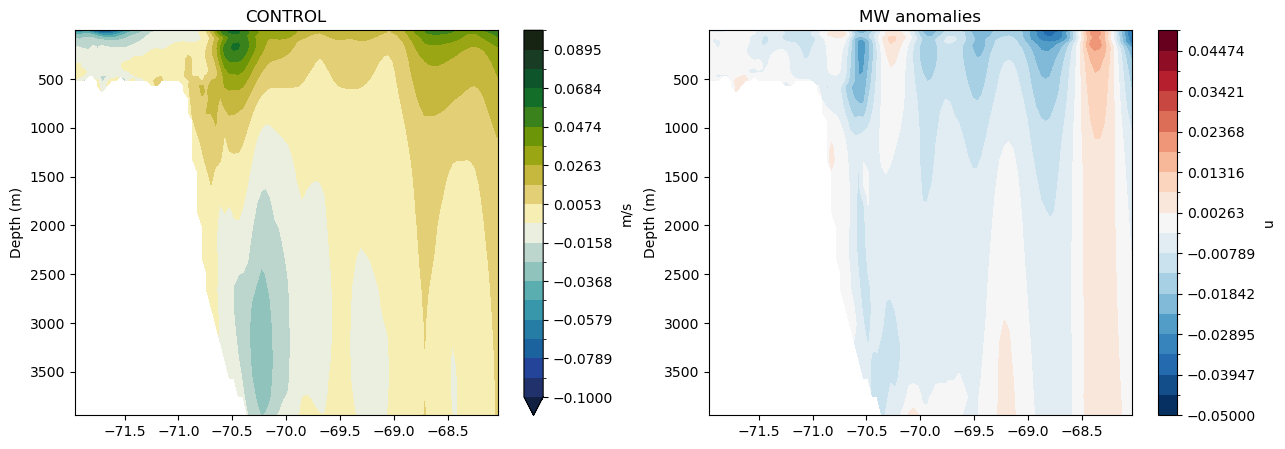

In [45]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
asc_warm_c.plot.contourf(ax = axs[0], levels = 20, vmin = -.1, vmax = .1, cmap = cm.cm.delta,
                          cbar_kwargs = {'label':'m/s'})
asc_warm_p.plot.contourf(ax = axs[1], levels = 20, vmin = -.05, vmax = .05, cmap = 'RdBu_r')
axs[0].set_title('CONTROL')
axs[1].set_title('MW anomalies')
for ax in axs:
    ax.invert_yaxis();
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('');

#### Question 3

Discuss the changes to teh ASC due to meltwater only. Look at, what was in the CONTROL, a bottom-intensified area. Do you think it still belongs to the same regime?

*Answer here*